## Attendance Prediction

### Alex Xu

In [267]:
#Imports
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib.pyplot import figure
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from scipy import stats
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sqlite3
import datetime
import seaborn as sns
import math
import statsmodels.api as sm 
import xgboost as xgb
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

#### Data

In [13]:
attendance = pd.read_csv('attendance.csv')
promo = pd.read_csv('promo.csv')
astros_home_attendance = attendance[attendance['home_team'] == 'Astros']
astros_away_attendance = attendance[attendance['away_team'] == 'Astros']
astros_promos = promo[promo['team_nickname'] == 'astros']

In [3]:
attendance.head()

,game_pk,game_time_local,day_night_code,venue_name,home_team,away_team,double_header,double_header_type,Sum of attendance
0,564734,4/4/2019 19:07,N,Angel Stadium,Angels,Rangers,N,NaN,42027
1,564735,4/5/2019 19:07,N,Angel Stadium,Angels,Rangers,N,NaN,41089
2,564736,4/6/2019 13:05,D,Angel Stadium,Angels,Rangers,N,NaN,31747
3,564737,4/7/2019 13:07,D,Angel Stadium,Angels,Rangers,N,NaN,42076
4,564738,4/8/2019 19:07,N,Angel Stadium,Angels,Brewers,N,NaN,28571


In [4]:
promo.head()

,game_pk,team_nickname,promotion_name
0,564735,angels,Bobblehead
1,564743,angels,Fireworks
2,564755,angels,Fireworks
3,564761,angels,Fireworks
4,564767,angels,Fireworks


### EDA

**This histogram indicates the attendance per game for the entire league over the course of the 2019, 2021, and 2022 seasons. As you can see, the average attendance of an MLB game in the dataset is just under 25000.**

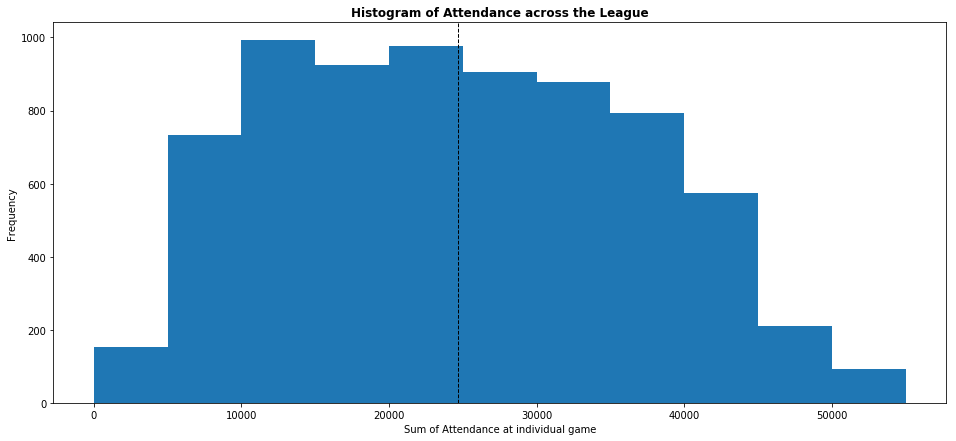

In [10]:
fig, ax = plt.subplots(figsize =(16, 7))

plt.axvline(attendance['Sum of attendance'].mean(), color='k', linestyle='dashed', linewidth=1)

ax.hist(attendance['Sum of attendance'],bins = np.arange(0,60000,5000))

plt.xlabel('Sum of Attendance at individual game')
plt.ylabel('Frequency')
  
plt.title('Histogram of Attendance across the League',
          fontweight ="bold")

plt.show()

**This histogram indicates the attendance per game for the Astros home game at Minute Maid Park over the course of the 2019, 2021, and 2022 seasons. As you can see, the average attendance of a game is just over 30000, well above the Major-League average.**

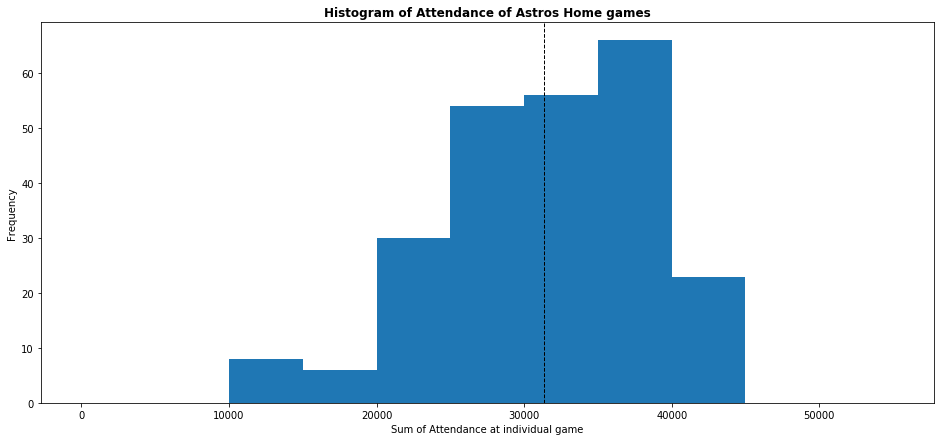

In [16]:
fig, ax = plt.subplots(figsize =(16, 7))

plt.axvline(astros_home_attendance['Sum of attendance'].mean(), color='k', linestyle='dashed', linewidth=1)

ax.hist(astros_home_attendance['Sum of attendance'],bins = np.arange(0,60000,5000))

plt.xlabel('Sum of Attendance at individual game')
plt.ylabel('Frequency')
  
plt.title('Histogram of Attendance of Astros Home games',
          fontweight ="bold")

plt.show()

**This histogram indicates the attendance per game for the Astros away games over the course of the 2019, 2021, and 2022 seasons. The distribution has much more variance than that of the home games.**

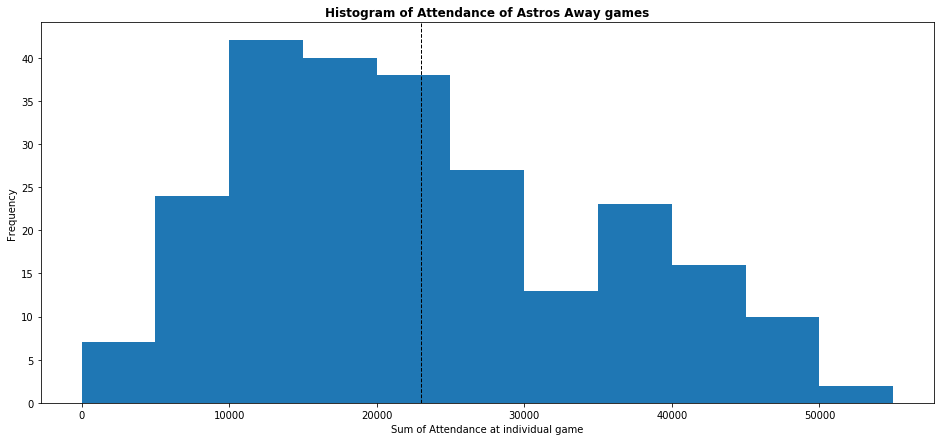

In [17]:
fig, ax = plt.subplots(figsize =(16, 7))

plt.axvline(astros_away_attendance['Sum of attendance'].mean(), color='k', linestyle='dashed', linewidth=1)

ax.hist(astros_away_attendance['Sum of attendance'],bins = np.arange(0,60000,5000))

plt.xlabel('Sum of Attendance at individual game')
plt.ylabel('Frequency')
  
plt.title('Histogram of Attendance of Astros Away games',
          fontweight ="bold")

plt.show()

### Now, because we know that the single series that we're predicting is a home series, I believe it makes more sense to focus data exploration on home games specifically.

**This chart shows the average attendance across the other teams the Astros played at home in the dataset.**

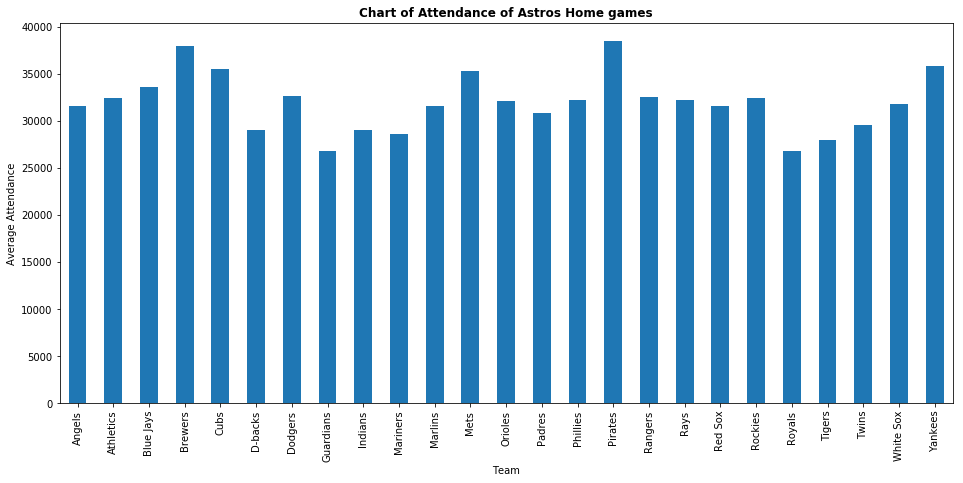

In [26]:
fig, ax = plt.subplots(figsize =(16, 7))

astros_home_attendance.groupby(by='away_team')['Sum of attendance'].mean().plot.bar()

plt.xlabel('Team')
plt.ylabel('Average Attendance')
  
plt.title('Chart of Attendance of Astros Home games',
          fontweight ="bold")

plt.show()

Note: Because my initial thinking was that in general there would be greater attendance the better the team the Astros were playing would be, I was initially surprised that the many of the top teams in terms of attendance were National League teams. My guess is that due to the relative rarity of interleague play with NL teams (which won't be the case beginning in this season), more fans may be incentivized to see their team play against a rarer opponent compared to division rivals for example.

While classifying a team as AL/NL or division may be considered as including outside information, what I can do is create a feature that determines how rare the matchup may be based on the home game data that I have. This can serve as a proxy to whether or not the team is a division rival, Al team, or NL team.

In [78]:
astros_home_attendance.groupby(by='away_team').size()

away_team
Angels       30
Athletics    29
Blue Jays     9
Brewers       2
Cubs          3
D-backs       5
Dodgers       2
Guardians     3
Indians       8
Mariners     31
Marlins       3
Mets          2
Orioles       9
Padres        4
Phillies      3
Pirates       3
Rangers      29
Rays          9
Red Sox      10
Rockies       4
Royals       10
Tigers       11
Twins        10
White Sox    11
Yankees       9
dtype: int64

Based on this data, I think a natural way to group the teams the Astros play at home is through a criteria like this:

- High: Greater than 15 total matchups 
- Medium: Between 6 and 15 total matchups
- Low: Below 6 total matchups

This places the following teams into the categories:

- High: Angels, Athletics, Mariners, Rangers
- Medium: Blue Jays, Indians/Guardians, Orioles, Rays, Red Sox, Royals, Tigers, Twins, White Sox, Yankees 
- Low: Brewers, Cubs, D-backs, Dodgers, Marlins, Mets, Padres, Phillies, Pirates, Rockies

In [84]:
high = ['Angels', 'Athletics', 'Mariners', 'Rangers']
med = ['Blue Jays', 'Indians','Guardians', 'Orioles','Rays', 'Red Sox', 'Royals', 'Tigers', 'Twins', 'White Sox', 'Yankees']
low = ['Brewers', 'Cubs', 'D-backs', 'Dodgers', 'Marlins', 'Mets', 'Padres','Phillies', 'Pirates', 'Rockies']

In [107]:
astros_home_attendance['team_freq'] = np.where(astros_home_attendance['away_team'].isin(high), 'High',
                                      np.where(astros_home_attendance['away_team'].isin(med), 'Med',
                                      np.where(astros_home_attendance['away_team'].isin(low), 'Low','None')))

In [35]:
astros_home_attendance[['Date', 'Time']] = astros_home_attendance["game_time_local"].apply(lambda x: pd.Series(str(x).split(" ")))
astros_away_attendance[['Date', 'Time']] = astros_away_attendance["game_time_local"].apply(lambda x: pd.Series(str(x).split(" ")))

In [37]:
astros_home_attendance[['Month', 'Day','Year']] = astros_home_attendance["Date"].apply(lambda x: pd.Series(str(x).split("/")))
astros_away_attendance[['Month', 'Day','Year']] = astros_away_attendance["Date"].apply(lambda x: pd.Series(str(x).split("/")))

**The bar chart shows the attendance throughout the year by month, attendance appears to peak during the summer.**

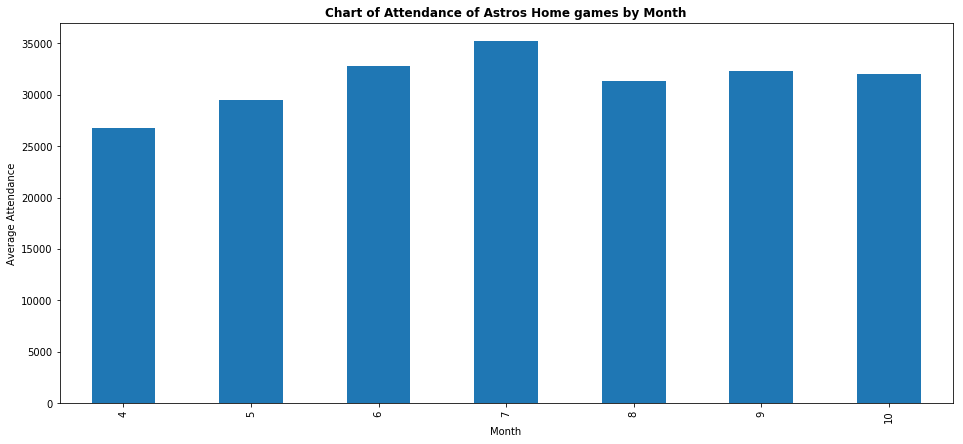

In [47]:
fig, ax = plt.subplots(figsize =(16, 7))

astros_home_attendance.groupby(by='Month')['Sum of attendance'].mean().plot.bar()

plt.xlabel('Month')
plt.ylabel('Average Attendance')
  
plt.title('Chart of Attendance of Astros Home games by Month',
          fontweight ="bold")

plt.show()

**This is the split of Astros Home games by daytime and nighttime, although daytime games have a higher average attendance, note that there are far more nighttime games (174) and the fact that daytime games (69) are more likely to be held on weekends.**

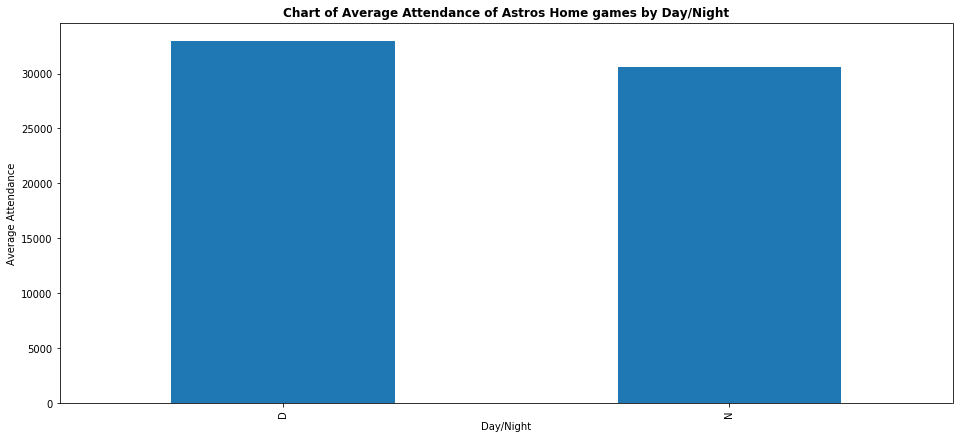

In [138]:
fig, ax = plt.subplots(figsize =(16, 7))

astros_home_attendance.groupby(by='day_night_code')['Sum of attendance'].mean().plot.bar()

plt.xlabel('Day/Night')
plt.ylabel('Average Attendance')
    
plt.title('Chart of Average Attendance of Astros Home games by Day/Night',
          fontweight ="bold")

plt.show()

In [120]:
astros_home_attendance['Date'] = pd.to_datetime(astros_home_attendance.Date)

In [130]:
# For the purposes of the exercise I'm including Friday as a part of the weekend
astros_home_attendance['weekday'] = np.where(astros_home_attendance['Date'].dt.dayofweek < 4, True,
                                    np.where(astros_home_attendance['Date'].dt.dayofweek > 3, False,None))

**After we split the games into Weekends vs Weekdays, we can clearly see that attendance is greater on average on the weekend, for reference, there were 122 weekend games, and 127 weekday games**

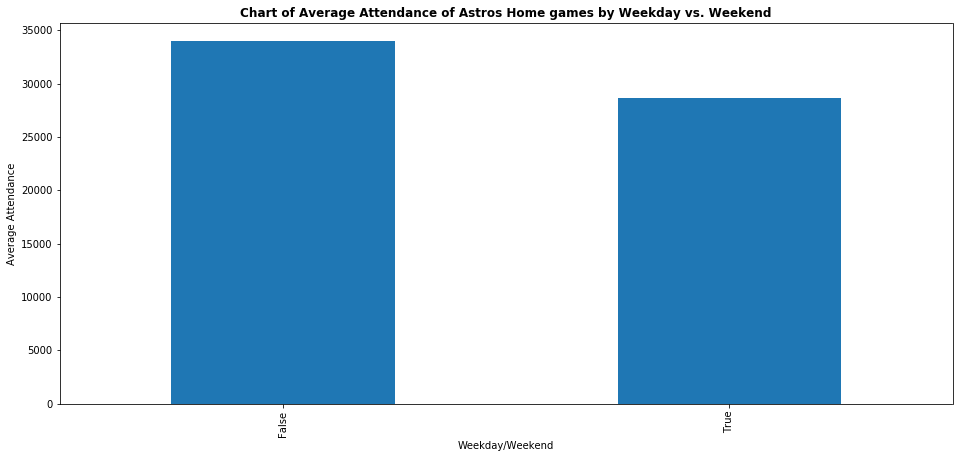

In [137]:
fig, ax = plt.subplots(figsize =(16, 7))

astros_home_attendance.groupby(by='weekday')['Sum of attendance'].mean().plot.bar()

plt.xlabel('Weekday/Weekend')
plt.ylabel('Average Attendance')
    
plt.title('Chart of Average Attendance of Astros Home games by Weekday vs. Weekend',
          fontweight ="bold")

plt.show()

**There was only one doubleheader the Astros played at home so I didn't think we needed to extensively analyze the difference.**

#### Promotional Analysis

In [64]:
astros_promos.groupby(by='promotion_name').size()

promotion_name
Bobblehead    47
Fireworks     24
dtype: int64

In [67]:
astros_home_attendance = astros_home_attendance.merge(astros_promos,how = 'left',on = 'game_pk').drop(columns = ['team_nickname'])

In [69]:
astros_home_attendance.promotion_name = astros_home_attendance.promotion_name.fillna('None')

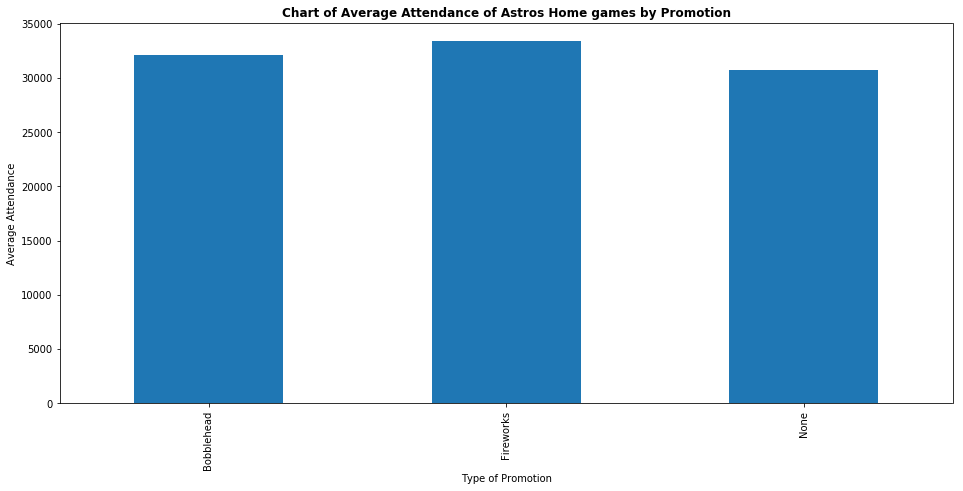

In [140]:
fig, ax = plt.subplots(figsize =(16, 7))

astros_home_attendance.groupby(by='promotion_name')['Sum of attendance'].mean().plot.bar()

plt.xlabel('Type of Promotion')
plt.ylabel('Average Attendance')
    
plt.title('Chart of Average Attendance of Astros Home games by Promotion',
          fontweight ="bold")

plt.show()

**While there are far more games that don't features promotionals like bobblehead giveaways or fireworks, we can see the average attendance is greater for promotional games than non-promotional games, with fireworks being the most popular.**

In [110]:
astros_home_attendance['Month'] = astros_home_attendance['Month'].astype(str)

In [153]:
astros_home_attendance['day_night_code'] = np.where(astros_home_attendance['day_night_code'] == 'D', True,
                                    np.where(astros_home_attendance['day_night_code'] == 'N', False,None))

In [169]:
astros_home_attendance['day_night_code'] = astros_home_attendance['day_night_code'].astype(int)
astros_home_attendance['weekday'] = astros_home_attendance['weekday'].astype(int)

### Feature Selection

Now that we've explored the data, we can select certain features for our model that we use to predict the attendance of any given game. Currently, the features I am thinking of using are: `Month`, `away_team`, `day_night_code`,`promotion_name`,`team_freq`, and `weekday`. Because we're dealing with a lot of categorical data, we'll need to create dummy variables for variables such as the month of the year, away team, and promotion.

In [186]:
feature_df = pd.DataFrame(astros_home_attendance,columns=['Month','day_night_code','away_team','promotion_name','team_freq','weekday'])

In [187]:
dummy_feature_data = pd.get_dummies(feature_df)

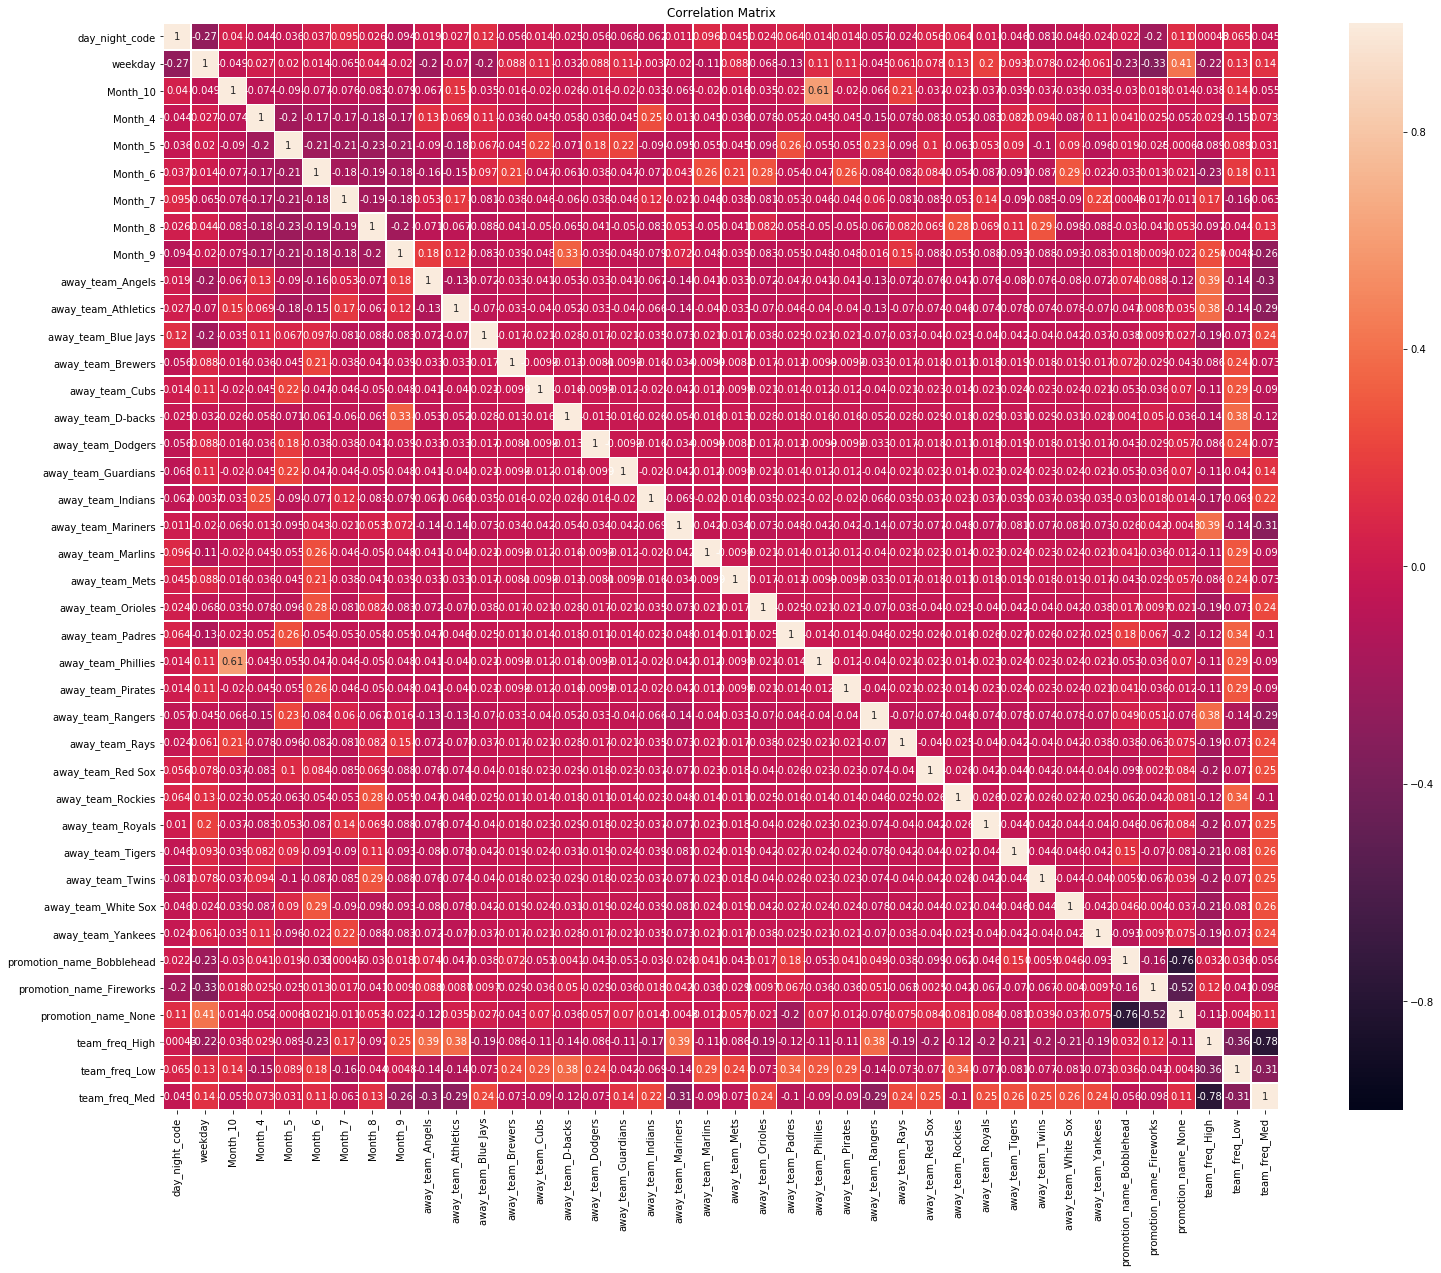

In [188]:
corrMatrix = dummy_feature_data.corr()
fig, ax = plt.subplots(figsize = (25, 20))

sns.heatmap(corrMatrix, annot = True, linewidths = 0.4, vmax = 1, vmin = -1)
plt.title('Correlation Matrix')
plt.show()

Below are the variables that are highly correlated with another variable. This actually shows the Dummy Variable Trap, since the two variables that are highly correlated are in the groups of promotion name and team frequency, which is why we must remove one of them from each group to avoid multicollinearity. Perhaps because there were so many teams, the correlation was not as present for each of the specific away teams, the same going for months, but just to be thorough, I decided to remove one dummy variable for the Months and away team columns (Month 10 and the Mets).

In [189]:
corrMatrix = abs(dummy_feature_data.corr())
upperTri = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k = 1).astype(np.bool))
vars_to_drop = [col for col in upperTri.columns if any(upperTri[col] >= 0.70)]

print(vars_to_drop)

['promotion_name_None', 'team_freq_Med']


In [190]:
vars_to_drop.extend(['Month_10','away_team_Mets'])

In [191]:
dummy_feature_data.drop(vars_to_drop, axis = 1, inplace = True)

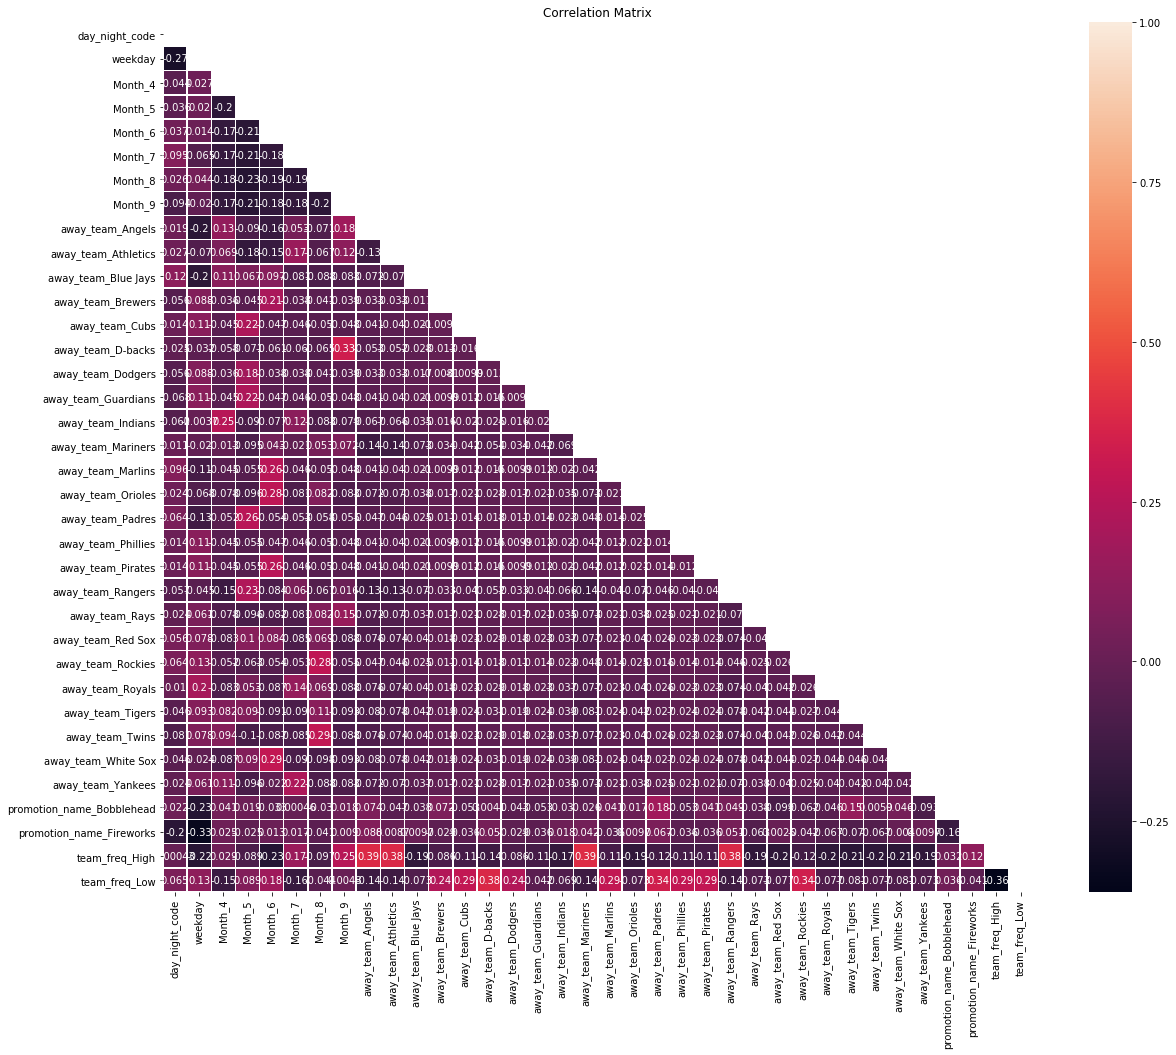

In [192]:
new_corr = dummy_feature_data.corr()
fig, ax = plt.subplots(figsize = (20, 16))

mask = np.triu(np.ones_like(new_corr))
sns.heatmap(new_corr, mask = mask, square = True, linewidths = 0.5, annot = True, annot_kws = {'size': 10},
            xticklabels = new_corr.columns, yticklabels = new_corr.columns)
plt.title('Correlation Matrix')

plt.show()

## Modeling

### Linear Model

In [232]:
x = dummy_feature_data
y = astros_home_attendance['Sum of attendance']
cols = list(x.columns)

model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 23, verbose = 10)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_vars = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars))

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
RFE Features: ['weekday', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'away_team_Angels', 'away_team_Brewers', 'away_team_Cubs', 'away_team_D-backs', 'away_team_Indians', 'away_team_Mariners', 'away_team_Marlins', 'away_team_Orioles', 'away_team_Padres', 'away_team_Phillies', 'away_team_Pirates', 'away_team_Rangers', 'away_team_Rockies', 'away_team_Royals', 'away_team_Tigers', 'away_team_Yankees', 'promotion_name_Fireworks', 'team_freq_High']


In [233]:
#VIF
x_rfe_model = dummy_feature_data[selected_vars]
x_rfe_model = sm.add_constant(x_rfe_model.values)
y_rfe_model = astros_home_attendance['Sum of attendance']


lm = sm.OLS(y_rfe_model, x_rfe_model)
result_rs = lm.fit()
print(result_rs.summary())

vif = pd.DataFrame()
vif['Feature'] = lm.exog_names
vif['VIF'] = [variance_inflation_factor(lm.exog, i) for i in range(lm.exog.shape[1])]
print(vif[vif['Feature'] != 'const'])

                            OLS Regression Results                            
Dep. Variable:      Sum of attendance   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     6.308
Date:                Mon, 27 Mar 2023   Prob (F-statistic):           1.48e-14
Time:                        15:38:01   Log-Likelihood:                -2494.7
No. Observations:                 249   AIC:                             5037.
Df Residuals:                     225   BIC:                             5122.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.334e+04   1068.841     31.195      0.0

In [236]:
def adj_r2(r_squared,n,p):
    adjusted = 1-(1-r_squared)*(n-1)/(n-p-1)
    return adjusted

In [258]:
X_lin = dummy_feature_data[selected_vars]
y_lin = astros_home_attendance['Sum of attendance']
                                       
X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size=0.2)
  
mlr = LinearRegression().fit(X_train, y_train)
y_predicted = mlr.predict(X_test)

In [259]:
# multiple linear regression results
print('------- Multiple Linear Regression -------')
print("Intercept: {}".format(mlr.intercept_))
print("Coefficients: {}".format(mlr.coef_))

print("R-squared: {}".format(metrics.r2_score(y_test, y_predicted)))
print("Adjusted R-squared: {}".format(adj_r2(metrics.r2_score(y_test, y_predicted),len(y_test),X_train.shape[1])))
mse = metrics.mean_squared_error(y_test, y_predicted)
print("RMSE: {}".format(math.sqrt(mse)))
print("MAE: {}".format(metrics.mean_absolute_error(y_test, y_predicted)))

------- Multiple Linear Regression -------
Intercept: 34314.46832040431
Coefficients: [-6593.07797621  3205.93283907  6200.45849662  1870.32907605
  4471.96253472 -1179.10911227  7052.67681673  8861.1096558
 -9343.26472962 -4317.60493333 -2303.51008469 -5768.40115947
 -2790.27050726 -1875.93947848  4541.27632247  7555.3434834
  1463.85430531  1866.28057975 -4272.82372162  1447.0408767
  2952.44262428 -1902.58652579 -2929.67438359]
R-squared: 0.26702589937877796
Adjusted R-squared: -0.38137426655537987
RMSE: 7046.604656625769
MAE: 5824.460259909541


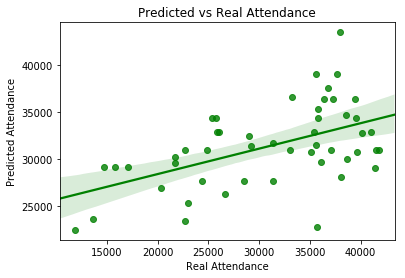

In [260]:
ax = sns.regplot(x=y_test,y=y_predicted, color="g").set(title='Predicted vs Real Attendance')
plt.xlabel("Real Attendance")
plt.ylabel("Predicted Attendance")
plt.show()

### Random Forest

In [429]:
model = RandomForestRegressor()

rfe = RFE(estimator = model, n_features_to_select = 25, verbose = 10)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_vars_forest = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars_forest))

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
RFE Features: ['day_night_code', 'weekday', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'away_team_Angels', 'away_team_Athletics', 'away_team_Blue Jays', 'away_team_D-backs', 'away_team_Indians', 'away_team_Mariners', 'away_team_Orioles', 'away_team_Rangers', 'away_team_Red Sox', 'away_team_Royals', 'away_team_Tigers', 'away_team_Twins', 'away_team_Yankees', 'promotion_name_Bobblehead', 'promotion_name_Fireworks', 'team_freq_High', 'team_freq_Low']


In [430]:
X_train, X_test, y_train, y_test = train_test_split(x[selected_vars_forest], y, test_size=0.2, random_state=42)
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_y_predicted = forest_model.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, forest_y_predicted))

print("------- Random Forest Regression -------")
print("R-squared: {}".format(forest_model.score(X_test,y_test)))
print("Mean RMSE: {}".format(forest_rmse))

------- Random Forest Regression -------
R-squared: 0.3755828138729578
Mean RMSE: 4861.484993270339


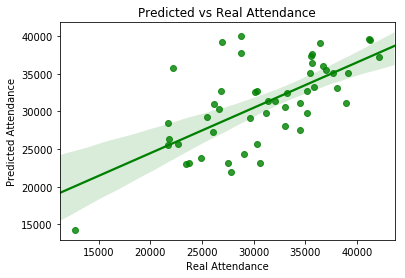

In [431]:
ax = sns.regplot(x=y_test,y=forest_y_predicted, color="g").set(title='Predicted vs Real Attendance')
plt.xlabel("Real Attendance")
plt.ylabel("Predicted Attendance")
plt.show()

### Boosted Trees

In [486]:
model = xgb.XGBRegressor(objective = 'reg:squarederror')

rfe = RFE(estimator = model, n_features_to_select = 16, verbose = 10)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_vars_boost = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars_boost))

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
RFE Features: ['weekday', 'Month_4', 'Month_5', 'Month_7', 'Month_8', 'Month_9', 'away_team_Angels', 'away_team_Blue Jays', 'away_team_Indians', 'away_team_Mariners', 'away_team_Royals', 'away_team_Tigers', 'away_team_Twins', 'away_team_Yankees', 'team_freq_High', 'team_freq_Low'

In [473]:
X_train, X_test, y_train, y_test = train_test_split(x[selected_vars_boost], y, test_size=0.2, random_state=42)
boost_model = xgb.XGBRegressor(objective = 'reg:squarederror')
boost_model.fit(X_train, y_train)
boost_y_predicted = boost_model.predict(X_test)
boost_rmse = np.sqrt(mean_squared_error(y_test, boost_y_predicted))

print("-------  Boosted Trees Regression -------")
print("R-squared: {}".format(boost_model.score(X_test,y_test)))
print("Mean RMSE: {}".format(boost_rmse))

-------  Boosted Trees Regression -------
R-squared: 0.42917364329898355
Mean RMSE: 4648.186385724635


##### Random Forest using XGBoost features

In [487]:
X_train, X_test, y_train, y_test = train_test_split(x[selected_vars_boost], y, test_size=0.2, random_state=42)
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_y_predicted = forest_model.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, forest_y_predicted))

print("------- Random Forest Regression -------")
print("R-squared: {}".format(forest_model.score(X_test,y_test)))
print("Mean RMSE: {}".format(forest_rmse))

------- Random Forest Regression -------
R-squared: 0.5245940315553013
Mean RMSE: 4241.933349095316


### Predicting the Phillies series

Although none of the regressors that were attempted produced fits that were reasonably accurate, we can still use the best model that we have to try and predict the outcome of the Phillies series. One thing that I noticed was interesting however by accident was that using the features selected with RFE with the **boosted trees** for the Random Forest producted better results than each model using their own, while the opposite was not the case.

In [488]:
selected_vars_boost

['weekday',
 'Month_4',
 'Month_5',
 'Month_7',
 'Month_8',
 'Month_9',
 'away_team_Angels',
 'away_team_Blue Jays',
 'away_team_Indians',
 'away_team_Mariners',
 'away_team_Royals',
 'away_team_Tigers',
 'away_team_Twins',
 'away_team_Yankees',
 'team_freq_High',
 'team_freq_Low']

In [476]:
regr = RandomForestRegressor()
regr.fit(x[selected_vars_boost], y)

RandomForestRegressor()

The three games the Astros play the Phillies can be vectorized as:

In [490]:
game = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1]

Because none of the promotional features were selected, and all of the games are weekend-night games, all against the Phillies, the model will therefore treat each game as the same and therefore predict each game equally.

In [491]:
print(regr.predict([game]))

[32915.97678968]


The best performing model that we tested was a Random Forest Model using the features selected from XGBoost RFE, that predicted each game as having an attendance of about 32916 people.

## Analysis

I began my analysis of the problem with exploratory data analysis to see if there were any patterns and trends that could be used to create features. This meant looking to see if there were signficant differences in attendance for games that were held in the day/night, weekday/weekend, whether there was a promotion, etc. After conducting the EDA, I narrowed down my list to six distinct features: `Month`, `away_team`, `day_night_code`,`promotion_name`,`team_freq`, and `weekday`. Because many of these variables were categorical, I also had ot create dummy variables and omit one dummy variable from each of the features to avoid the dummy variable trap.

After that, I needed to see if there were any variables that had significant correlations with the target variable of attendance, as well as using Residual Feature Elimination for each of the models that I tried (Linear Regression, Random Forest, and Boosted Trees). Unfortunately, with the limited expected time that I had to complete a project like this, I was only able to do minimal tuning of the number of features and hyperparameters for each of the models. However, none of the models that were utilized were able to produce fits that were of sufficient quality, as I determined that the best performing model was the Random Forest Regressor that used the features selected by the RFE-analysis on the **boosted** trees, which had R-squared metrics of around .52.

One thing I was very surprised about was the fact that none of the best performing models included the promotional features in their feature sets. This was very surpising as we saw that the average attendance of home games was greater than that of the non-promotional nights. In addition, when I tried adding them into the feature set of the best-performing model just to try, the addition of each dummy promotional variable saw a marked decrease in test fit. 

Therefore, my conclusion is that the most signficant variables determined by the model will be the day of the week, time of the year, the team that is playing, as well as how frequent that matchup is. Other considerations that I would have liked to try if I had more time would be to see if this was the case with other teams in larger or smaller markets as well as their promotional data for example, in addition to that, if the other team's record was better or worse in any given year. Another consideration is geographic proximity, are away team fans close enough where we could expect many of them to travel to their games, this also may be a more important matchup given these teams made the World Series a year ago.

## Citations

- https://machinelearningmastery.com/
- https://scikit-learn.org/stable/modules/classes.html
- https://pandas.pydata.org/docs/index.html
- https://matplotlib.org/stable/index.html
- https://www.statsmodels.org/stable/index.html